In [1]:
import nltk
import numpy as np
import math
from collections import Counter, defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, fbeta_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# getting data and tagset
nltk.download('universal_tagset')
nltk.download('brown')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [3]:
# Start and end tokens
startToken = '^'
endToken = '$'
taggedSentences = nltk.corpus.brown.tagged_sents(tagset='universal')

In [4]:
# Adding the start and end token
finalTaggedSentences=[]
for i in range(len(taggedSentences)):
    temp=[]
    sentence = taggedSentences[i]
    # Start and end tokens will have the same tag
    temp.append((startToken,startToken))
    for word,tag in sentence:
        temp.append((word.lower(),tag))
    temp.append((endToken,endToken))
    finalTaggedSentences.append(temp)

taggedSentences = finalTaggedSentences

In [5]:
def Training(sentences):
    listOfAllTuples = []
    for sentence in sentences:
        for word, tag in sentence:
            listOfAllTuples.append((word, tag))
    POS_TagCounts = Counter(tag for _, tag in listOfAllTuples)
    POS_TaggedWords = defaultdict(Counter)
    for word, pos_tag in listOfAllTuples:
        POS_TaggedWords[word][pos_tag] += 1
    tagTransitionCount = defaultdict(Counter)
    for sentence in sentences:
        for i in range(len(sentence) - 1):
            tagTransitionCount[sentence[i][1]][sentence[i+1][1]] += 1

    return POS_TagCounts, POS_TaggedWords, tagTransitionCount


In [6]:
def generateTransitionProbability(tag1, tag2, POS_tag_counts, tagTransitionCount):
    Tag1Tag2Count = tagTransitionCount[tag1][tag2]
    Tag1TotalCount = POS_tag_counts[tag1]
    conditionalProbability = Tag1Tag2Count / Tag1TotalCount
    if conditionalProbability == 0:
        conditionalProbability = 1e-5
    return conditionalProbability

In [7]:
def generateLexicalProbability(word, tag, POS_TagCounts, POS_TaggedWords):
    word_tag = POS_TaggedWords[word][tag]
    tag_total = POS_TagCounts[tag]
    res = (word_tag + 1) / (tag_total + len(POS_TaggedWords))
    return res

In [8]:
def ViterbiAlgorithm(untaggedSentence, POS_TagCounts, POS_TaggedWords, Tag_transition_count):
    n = len(untaggedSentence)
    prev = defaultdict(float)
    curr = defaultdict(float)
    parent = defaultdict(Counter)

    for tag in POS_TagCounts:
        prev[tag] = 0.0
    prev[startToken] = 0.0
    parent[0][startToken] = 0

    for i in range(1, n - 1):
        word = untaggedSentence[i]
        for tag in POS_TagCounts:
            curr[tag] = float('-inf')
            for prev_tag in POS_TagCounts:
                temp = prev[prev_tag] + math.log(generateLexicalProbability(word, tag, POS_TagCounts, POS_TaggedWords)) + math.log(generateTransitionProbability(prev_tag, tag, POS_TagCounts, Tag_transition_count))
                if temp > curr[tag]:
                    curr[tag] = temp
                    parent[i][tag] = prev_tag

        for tag in POS_TagCounts:
            prev[tag] = curr[tag]

    final_tags = ['$' for i in range(n)]
    final_tags[n - 2] = max(POS_TagCounts, key=lambda tag: curr[tag])

    for i in range(n - 3, 0, -1):
        final_tags[i] = parent[i + 1][final_tags[i + 1]]
    final_tags[0] = startToken
    return final_tags

In [9]:
LastTagTransitionCount = defaultdict(Counter)
LastPOS_TagCounts = defaultdict(Counter)
LastPOS_TaggedWords =  defaultdict(Counter)

numberOfFolds = 5
avg_accu=0.0
kfold = KFold(n_splits=numberOfFolds, shuffle=True, random_state=1)

taggedSentences = np.array(taggedSentences,dtype='object')
predictedList = []
trueList = []
for fold, (train, test) in enumerate(kfold.split(taggedSentences)):
    trainSentences = taggedSentences[train]
    testSentences = taggedSentences[test]
    trainedPOS_TagCounts,trainedPOS_TaggedWords,trainedTagTransitionCounts = Training(trainSentences)
    if(fold==3):
        LastPOS_TagCounts = trainedPOS_TagCounts
        LastPOS_TaggedWords = trainedPOS_TaggedWords
        LastTagTransitionCount = trainedTagTransitionCounts
    predictions = []
    truth = []

    for sentence in testSentences:
        untagged_sentence = [word for word,tag in sentence]
        prediction = ViterbiAlgorithm(untagged_sentence,trainedPOS_TagCounts,trainedPOS_TaggedWords,trainedTagTransitionCounts)
        for i in range(1,len(prediction)-1):
            predictions.append(prediction[i])
            truth.append(sentence[i][1])

    predictedList.append(np.array(predictions))
    trueList.append(np.array(truth))
    accuracy = accuracy_score(trueList[-1],predictedList[-1],normalize=True)
    avg_accu=avg_accu+(accuracy*100)
    print(f'Accuracy for Fold {fold + 1} : {accuracy*100}')
avg_accu=avg_accu/5
print(avg_accu)

Accuracy for Fold 1 : 93.85365979581037
Accuracy for Fold 2 : 93.8550667121048
Accuracy for Fold 3 : 93.81574135817074
Accuracy for Fold 4 : 93.90884962593302
Accuracy for Fold 5 : 93.82870068593975
93.85240363559173


In [10]:

Metrics = {
    'f1score': 0,
    'f2score': 0,
    'fhalfscore':0,
    'precision': 0,
    'recall': 0
}

for i in range(numberOfFolds):
    f1ScoreForFold = fbeta_score(trueList[i], predictedList[i], beta=1, average='weighted', zero_division=0)
    Metrics['f1score'] += f1ScoreForFold
    f2ScoreForFold = fbeta_score(trueList[i], predictedList[i], beta=2, average='weighted', zero_division=0)
    Metrics['f2score'] += f2ScoreForFold
    fhalfScoreForFold = fbeta_score(trueList[i], predictedList[i], beta=0.5, average='weighted', zero_division=0)
    Metrics['fhalfscore'] += fhalfScoreForFold
    precisionForFold = precision_score(trueList[i], predictedList[i], average='weighted', zero_division=0)
    Metrics['precision'] += precisionForFold
    recallForFold = recall_score(trueList[i], predictedList[i], average='weighted', zero_division=0)
    Metrics['recall'] += recallForFold
    print(f'Metrics for fold - {i+1}')
    print(f'\tPrecision: {precisionForFold*100}')
    print(f'\tRecall: {recallForFold*100}')
    print(f'\tF1 Score: {f1ScoreForFold*100}')
    print(f'\tF2 Score: {f2ScoreForFold*100}')
    print(f'\tF0.5 Score: {fhalfScoreForFold*100}')

for score_name in Metrics:
    Metrics[score_name] /= numberOfFolds

print('Average Metrics :')
print(f'Precision: {Metrics["precision"]*100}')
print(f'Recall: {Metrics["recall"]*100}')
print(f'F1 Score: {Metrics["f1score"]*100}')
print(f'F2 Score: {Metrics["f2score"]*100}')
print(f'F0.5 Score: {Metrics["fhalfscore"]*100}')



Metrics for fold - 1
	Precision: 94.01921319520419
	Recall: 93.85365979581037
	F1 Score: 93.87136837809635
	F2 Score: 93.84504368825026
	F0.5 Score: 93.94427391154831
Metrics for fold - 2
	Precision: 93.99378040311557
	Recall: 93.8550667121048
	F1 Score: 93.85929743040049
	F2 Score: 93.84114813417322
	F0.5 Score: 93.92415909075133
Metrics for fold - 3
	Precision: 93.98217612580517
	Recall: 93.81574135817074
	F1 Score: 93.82884376988268
	F2 Score: 93.80386092406845
	F0.5 Score: 93.90394516079289
Metrics for fold - 4
	Precision: 94.07324934497113
	Recall: 93.90884962593302
	F1 Score: 93.92716922457308
	F2 Score: 93.90072346802705
	F0.5 Score: 93.99937067754678
Metrics for fold - 5
	Precision: 94.0307225853534
	Recall: 93.82870068593975
	F1 Score: 93.85989614758783
	F2 Score: 93.82372122918807
	F0.5 Score: 93.94572985355144
Average Metrics :
Precision: 94.0198283308899
Recall: 93.85240363559173
F1 Score: 93.8693149901081
F2 Score: 93.84289948874141
F0.5 Score: 93.94349573883815


In [11]:
def generateClassificationReport(trueList,predictionList):
    tagset = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    report = 0
    support = 0
    check = 0
    for i in range(5):
        cr = classification_report(trueList[i],predictionList[i],labels=tagset,zero_division=0)
        cr = cr.replace('macro avg', 'macro')
        cr = cr.replace('micro avg', 'micro')
        cr = cr.replace('weighted avg', 'weighted')
        cr = cr.replace('\n\n', '\n')
        lines = cr.split('\n')
        classes , mat , sup = [], [], []
        for line in lines[1:]:
            a = line.strip().split()
            if len(a) < 2:
                continue
            temp = [float(x) for x in a[1: len(a) - 1]]
            sup.append(int(a[-1]))
            classes.append(a[0])
            mat.append(temp)
        mat = np.array(mat)
        sup = np.array(sup)
        if(i==0):
            report = mat
            support = sup
        else:
            report=report+mat
            support=support+sup
    report = report/5.0
    support = support/5.0
    xticklabels = ['Precision', 'Recall', 'F1-Score']
    yticklabels = ['{0}[{1}]'.format(classes[i], sup_i) for i, sup_i in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(18,10))
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    plt.imshow(report, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels)
    plt.yticks(np.arange(len(classes)), yticklabels)
    for i in range(report.shape[0]):
        for j in range(report.shape[1]):
            plt.text(j, i, format(report[i, j], '.2f'), horizontalalignment="center", verticalalignment="center" ,fontsize=14)
    plt.savefig('classificationReport.png')


In [12]:
def generateConfusionMatrix(trueList,predictionList):
    list_of_tags = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    count = 0
    mat = 0
    for y_true,y_pred in zip(trueList,predictionList):
        cm = confusion_matrix(y_true,y_pred,labels=list_of_tags)
        count=count+1
        if(count==1):
            mat = cm
        else:
            mat = mat+cm

    mat = mat.astype('float')
    mat = mat/count
    mat_confusion_matrix = mat/np.sum(mat, axis=1, keepdims=True) #With Normalization
    #mat_confusion_matrix = mat  #Without Normalization
    plt.clf()
    fig, ax = plt.subplots(figsize=(12,10))
    tick_marks = np.arange(len(list_of_tags))
    plt.xticks(tick_marks, list_of_tags)
    plt.yticks(tick_marks, list_of_tags)
    for i in range(mat_confusion_matrix.shape[0]):
            for j in range(mat_confusion_matrix.shape[1]):
                plt.text(j, i, format(mat_confusion_matrix[i, j], '0.2f'), horizontalalignment="left")
    plt.imshow(mat_confusion_matrix,interpolation='nearest',cmap=plt.cm.cool)
    plt.colorbar()
    plt.savefig('confusionMatrix.png')


<Figure size 640x480 with 0 Axes>

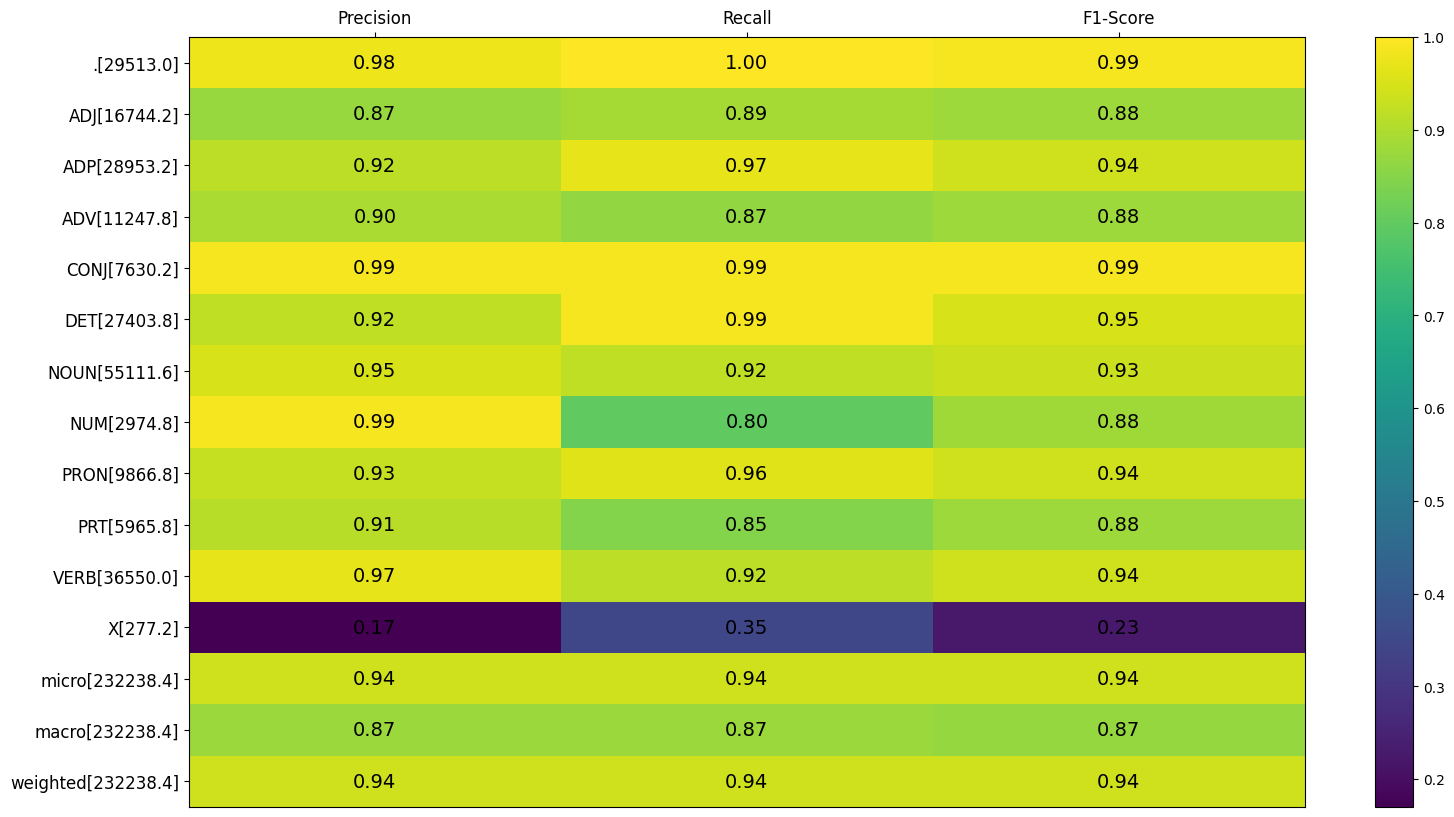

In [13]:

generateClassificationReport(trueList,predictedList)


<Figure size 640x480 with 0 Axes>

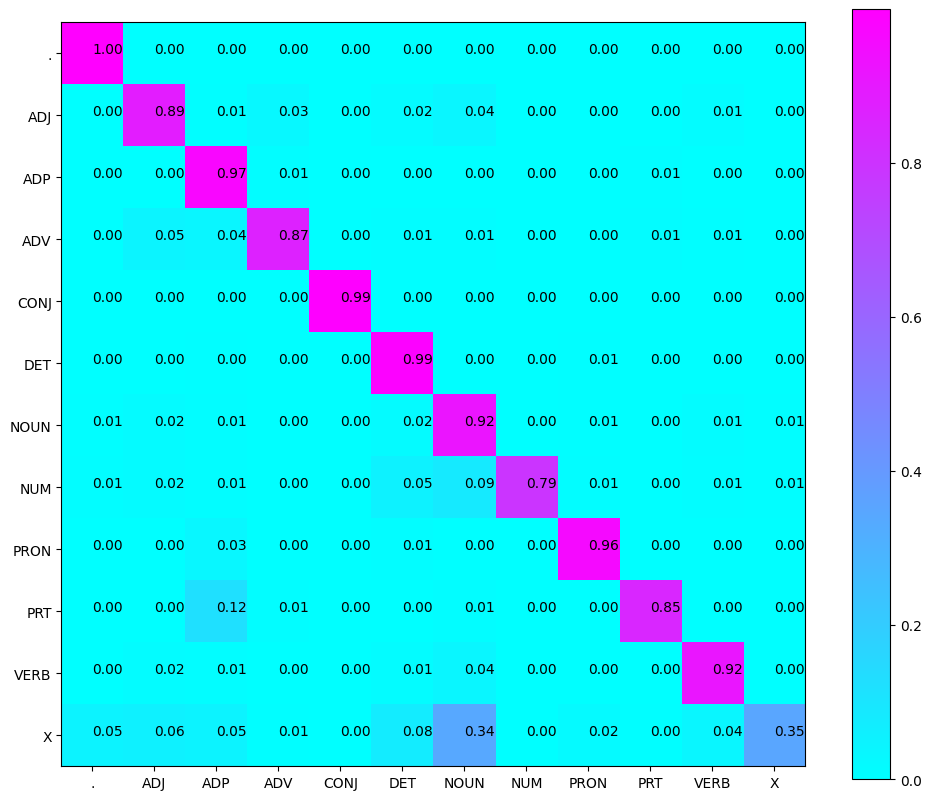

In [14]:

generateConfusionMatrix(trueList,predictedList)


In [15]:
def getPOS_Tagging(untaggedSentence,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count):
    untaggedSentence = untaggedSentence.lower()
    sentence_t = untaggedSentence.split()
    sentence_t = ['^'] + sentence_t + ['$']
    return ViterbiAlgorithm(sentence_t,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count)


In [16]:
promptSentence = 'He likes to eat chocolates'
getPOS_Tagging(promptSentence,LastPOS_TagCounts,LastPOS_TaggedWords,LastTagTransitionCount)

['^', 'PRON', 'VERB', 'PRT', 'VERB', 'ADV', '$']